In [1]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import librosa
import os
import pandas as pd
import tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf

2021-09-17 13:45:51.980281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def load_wav(path, sr):
    return librosa.core.load(path, sr=sr)[0]

def trim_silence(wav, top_db=23, fft_size=512,hop_size=128):
    return librosa.effects.trim(wav, top_db= top_db, frame_length=fft_size, hop_length=hop_size)[0]

def spectral_features(y, sr, n_fft, window_size):
    S, phase = librosa.magphase(librosa.stft(y=y,n_fft=n_fft, hop_length=window_size+1))

    centroid = librosa.feature.spectral_centroid(S=S,n_fft=n_fft)
    bandwidth = librosa.feature.spectral_bandwidth(S=S)
    flatness = librosa.feature.spectral_flatness(S=S)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)

    S = np.abs(librosa.stft(y,n_fft=n_fft,hop_length=window_size+1))
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    
    return np.concatenate([centroid, bandwidth, flatness, rolloff, contrast], axis = 0)

In [3]:
#Use old segmentation
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

---
# 1-Prepare Data
---



In [4]:
dic = {}
dic ['id'] = []
dic['path'] = []
dic['covid_status'] = []

path = "/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data"
sub_dir = os.listdir(path)
#print(sub_dir)
for _dir in sub_dir:        
    csv_name = path + "/" + _dir +'/' +_dir + '.csv'
    
    data = pd.read_csv(csv_name)
    
    for i in range(len(data)):
        data_dir = path + "/" + _dir +'/' +_dir+ '/'+ data['id'][i]
        #print(data_dir)
        if os.path.isdir(data_dir):
            temp = os.listdir(data_dir)
            for file in temp:
                if file[:2] == 'c_':
                    #print(file)
                    dic['id'].append(data['id'][i])
                    dic['path'].append(path + "/" + _dir +'/' +_dir+ '/'+ data['id'][i] + '/' + file)
                    dic['covid_status'].append(data['covid_status'][i])

In [5]:
df = pd.DataFrame.from_dict(dic)

In [6]:
df

,id,path,covid_status
0,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
1,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
2,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
3,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
4,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
...,...,...,...
600,3fKAFFPrGTZTay5GlkoipIjRUPL2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
601,3fKAFFPrGTZTay5GlkoipIjRUPL2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
602,xb5Zffvkf5MqrUPju4A98njfRMy1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
603,xb5Zffvkf5MqrUPju4A98njfRMy1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy


In [7]:
df['covid_status'].unique()

array(['positive_mild', 'positive_moderate', 'healthy',
       'resp_illness_not_identified', 'no_resp_illness_exposed'],
      dtype=object)

In [8]:
is_healthy = df['covid_status'] == 'healthy'
healthy = df[is_healthy]

#is_no_resp_illness_exposed
is_no_resp_illness_exposed = df['covid_status'] == 'no_resp_illness_exposed'
no_resp_illness_exposed = df[is_no_resp_illness_exposed]

#resp_illness_not_identified
is_resp_illness_not_identified = df['covid_status'] == 'resp_illness_not_identified'
resp_illness_not_identified = df[is_resp_illness_not_identified]

#positive_mild
is_positive_mild = df['covid_status'] == 'positive_mild'
positive_mild = df[is_positive_mild]

#positive_asymp
is_positive_asymp = df['covid_status'] == 'positive_asymp'
positive_asymp = df[is_positive_asymp]

#positive_moderate
is_positive_moderate = df['covid_status'] == 'positive_moderate'
positive_moderate = df[is_positive_moderate]

#recovered_full
is_recovered_full = df['covid_status'] == 'recovered_full'
recovered_full = df[is_recovered_full]

In [9]:
healthy

,id,path,covid_status
71,Jw7YMfwGqMX22UbHh1TTgYMTYWs1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
72,Jw7YMfwGqMX22UbHh1TTgYMTYWs1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
73,Jw7YMfwGqMX22UbHh1TTgYMTYWs1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
74,tM8IvvHCyCXpEsx5T6egMVLj7Lu1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
75,tM8IvvHCyCXpEsx5T6egMVLj7Lu1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
...,...,...,...
600,3fKAFFPrGTZTay5GlkoipIjRUPL2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
601,3fKAFFPrGTZTay5GlkoipIjRUPL2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
602,xb5Zffvkf5MqrUPju4A98njfRMy1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy
603,xb5Zffvkf5MqrUPju4A98njfRMy1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy


In [10]:
positive_mild

,id,path,covid_status
0,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
1,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
2,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
3,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
4,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
...,...,...,...
479,ZpsUydPUXygszeJSVtTFjbsqoNQ2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
480,ZpsUydPUXygszeJSVtTFjbsqoNQ2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
481,ZpsUydPUXygszeJSVtTFjbsqoNQ2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild
482,ZpsUydPUXygszeJSVtTFjbsqoNQ2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_mild


In [11]:
positive_asymp

,id,path,covid_status


In [12]:
positive_moderate

,id,path,covid_status
49,w7pdOIUnHPRfYLXVVRtIRsOjGnr2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
50,w7pdOIUnHPRfYLXVVRtIRsOjGnr2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
51,w7pdOIUnHPRfYLXVVRtIRsOjGnr2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
52,w7pdOIUnHPRfYLXVVRtIRsOjGnr2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
66,joORHxc0iCTwgP7Uh5SM5N7rnnf2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
67,joORHxc0iCTwgP7Uh5SM5N7rnnf2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
68,joORHxc0iCTwgP7Uh5SM5N7rnnf2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
69,joORHxc0iCTwgP7Uh5SM5N7rnnf2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
70,joORHxc0iCTwgP7Uh5SM5N7rnnf2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate
82,QjBZv868nydJzk0ZzwgKDHSG6Q82,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,positive_moderate


In [13]:
len_healthy = len(healthy)
len_resp_illness_not_identified = len(resp_illness_not_identified)
len_no_resp_illness_exposed = len(no_resp_illness_exposed)
len_positive_mild = len(positive_mild)
len_positive_asymp= len(positive_asymp)
len_positive_moderate = len(positive_moderate)
len_recovered_full = len(recovered_full)
print(len_healthy)
print(len_positive_mild+len_positive_moderate)

292
272


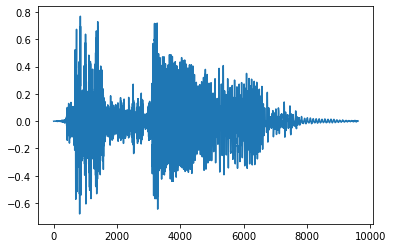

In [40]:
y = load_wav(healthy['path'][72], 24000)
plt.plot(y)

### 기침소리만 잘라내기

In [27]:
from tqdm import tqdm
sr = 24000

#healthy_seg = {}
#healthy_seg['id'] = []
#healthy_seg['data'] = []
#healthy_seg['covid_status'] = []

data_seg = {}
data_seg['id'] = []
data_seg['data'] = []
data_seg['covid_status'] = []

#healthy = healthy.reset_index(drop=True)
#covid = covid.reset_index(drop=True)

for i in tqdm(range(len(df['path']))):
    file = df['path'][i]
    y = load_wav(file, sr)
    cough_segments, cough_mask = segment_cough(y,sr)
    for j in range(len(cough_segments)):
        data_seg['id'].append(df['id'][i])
        data_seg['data'].append(cough_segments[j])
        data_seg['covid_status'].append(df['covid_status'][i])
    '''      
    elif df['covid_status'][i] == 'positive_mild':
        file = df['path'][i]
        y = load_wav(file, sr)
        cough_segments, cough_mask = segment_cough(y,sr)
        for j in range(len(cough_segments)):
            data_seg['id'].append(df['id'][i])
            data_seg['data'].append(cough_segments[j])
            data_seg['covid_status'].append('covid')
            
    elif df['covid_status'][i] == 'positive_moderate':
        file = df['path'][i]
        y = load_wav(file, sr)
        cough_segments, cough_mask = segment_cough(y,sr)
        for j in range(len(cough_segments)):
            data_seg['id'].append(df['id'][i])
            data_seg['data'].append(cough_segments[j])
            data_seg['covid_status'].append('covid')
    '''
    

100%|█████████████████████████████████████████| 605/605 [00:44<00:00, 13.62it/s]


In [28]:
ds = pd.DataFrame.from_dict(data_seg)
ds

,id,data,covid_status
0,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,"[-0.057276655, -0.05591783, -0.042026363, -0.0...",positive_mild
1,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,"[0.11416311, 0.13142514, 0.14133038, 0.1383039...",positive_mild
2,wXChdMlWemXwRdX642WnX6JbYfA2,"[-7.1607035e-05, -9.1359536e-05, -7.366793e-05...",positive_mild
3,wXChdMlWemXwRdX642WnX6JbYfA2,"[-0.00039237118, -0.00039568433, 0.00010765187...",positive_mild
4,wXChdMlWemXwRdX642WnX6JbYfA2,"[4.7341793e-05, 4.3208696e-05, 5.5425658e-06, ...",positive_mild
...,...,...,...
148,sSRc22AD2BNCZwcHILpCD0pbp5l2,"[0.0018230452, 0.0038598964, 0.0046669384, 0.0...",resp_illness_not_identified
149,sSRc22AD2BNCZwcHILpCD0pbp5l2,"[0.0018270906, 0.0013317186, -0.00070863013, -...",resp_illness_not_identified
150,DVdBgadmkvN8uJy0Q1kPTOBdUhu2,"[-0.0009945513, -0.0010488272, -0.00069922133,...",healthy
151,DVdBgadmkvN8uJy0Q1kPTOBdUhu2,"[-0.007160256, -0.0015677367, 0.006104764, 0.0...",healthy


In [34]:
is_pm = ds['covid_status'] == 'positive_mild'
pm = ds[is_pm]#72

is_h = ds['covid_status'] == 'healthy'
he = ds[is_h] #51

is_pmo = ds['covid_status'] == 'positive_moderate'
pmo = ds[is_pmo] #18
len(pmo)

18

+ healthy 292개
+ covid 272개

In [14]:
#healthy = healthy[:600]
#covid = pd.concat([COVID19, positive_mild, positive_moderate])
#healthy_coswara = healthy_coswara[:100]
covid = pd.concat([positive_mild, positive_moderate])
covid['covid_status'] = 'covid'
covid
#healthy_coswara

,id,path,covid_status
0,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
1,1e8i6Q47ewbzrTiKqIeOLEvPv2Z2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
2,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
3,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
4,G5kUP2QOpVSyjK6Q9rzblmTU9vW2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
...,...,...,...
485,NAL6D2MCyQbiZUGtdQixl39IH3X2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
486,NAL6D2MCyQbiZUGtdQixl39IH3X2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
487,NAL6D2MCyQbiZUGtdQixl39IH3X2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid
488,NAL6D2MCyQbiZUGtdQixl39IH3X2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,covid


---
# 2- Data Sampling 
---

In [15]:
healthy_path = list(healthy['path'])  #0
covid_path = list(covid['path'])      #1

X = np.concatenate([healthy_path, covid_path])
Y = np.concatenate([np.zeros(292),np.ones(272)])
print(X.shape[0])

564


In [16]:
idx = np.arange(X.shape[0])
np.random.shuffle(idx)

X = X[idx]
Y = Y[idx]

In [17]:
'''
#7:3 790:344
Training_filename = X[:790]
Test_filename = X[790:]
Training_label = Y[:790]
Test_label = Y[790:]
'''
#7:3
Training_filename = X[:390]
Test_filename = X[390:]
Training_label = Y[:390]
Test_label = Y[390:]

### MFCC Extraction

In [18]:
window_size = 250 # 특징 추출을 위한 윈도우 크기
n_mfcc = 13 #MFCC 계수 크기  ##virufy는 39
sr =16000
rescaling_max=0.999
time_step = 15
n_fft = 512

In [19]:
Training_vector = []
Feature_Set = []
for ix in range(len(Training_filename)):
    # 파일 읽어오기
    print (str(ix)+ "\t" + str(Training_label[ix]) + "\t" + Training_filename[ix])
    
    s =  load_wav(Training_filename[ix], sr)
    
    #trim silence
    y = trim_silence(s)
    
    #rescale wav
    y = y / np.abs(y).max() * rescaling_max
    
    S = librosa.feature.melspectrogram(y=y, hop_length = window_size+1,n_mels = n_fft, sr=sr)
    log_S = librosa.amplitude_to_db(S, ref = np.max)
    
    mfcc = librosa.feature.mfcc(S=log_S,sr=sr, n_mfcc=n_mfcc)
    Feature_Set.append(mfcc)
    
    #Spectral feature
    # 1. centroid
    cent = features.spectral_centroid(y_sub,sr,window_size)
    Feature_Set.append(cent)
                
    # 2. bandwidth
    bandwidth = features.spectral_bandwidth(y_sub,sr,window_size)
    Feature_Set.append(bandwidth)

    # 3. contrast
    contrast = features.spectral_contrast(y_sub,sr,window_size)    
    for i in range(len(contrast)):
        Feature_Set = Feature_Set + contrast[i].tolist()


    # 4. flatness
    flatness = features.spectral_flatness(y_sub,sr,window_size)
    Feature_Set.append(flatness)


    # 5. rolloff
    rolloff = features.spectral_rolloff(y_sub,sr,window_size)
    Feature_Set.append(rolloff)


    # Chroma
    chroma_vec = features.chroma(y_sub,sr,window_size)    
    for i in range(len(chroma_vec)):
        Feature_Set = Feature_Set + chroma_vec[i].tolist()
                    
    #Feature_list.append(Feature_Set)
    feature_set_cnt = feature_set_cnt + 1
    
    Training_vector.append(Feature_Set)

0	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200911/20200911/BDygu23lyUbBq2NlqfzRxGoMm9B2/c_heavy_2.wav
1	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/YRiIODBG3RXPbDttwztMhsXg1rv2/c_shallow_2.wav
2	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201031/20201031/d6jLMHIh9wflqh7d1f7vmlpn4q53/c_heavy_1.wav
3	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200417/20200417/chMsCb2SqaYxVB1lc93vPGPa5ho1/c_Track 006.wav
4	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200419/20200419/XlPcBLOUHdNZwOeNJvVy1KfjQDf2/c_Track 004.wav
5	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/GZM32y1Sy6X9D9hfrrvpTdPfmoV2/c_Track 004.wav
6	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200416/20200416/3fKAFFPrGTZTay5GlkoipIjRUPL2/c_Track 006.wav
7	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/g

64	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/05acPS4aRGfvuOfku11Za8zve8i2/c_heavy_2.wav
65	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200824/20200824/ptuwF1pj4ibIoVuZmt4nKb5naiZ2/c_heavy_4.wav
66	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/BTq6ZzkM2pdcUmgtOHVP4GG5wvZ2/c_heavy_3.wav
67	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201031/20201031/iS29Ewab4XQHypUcZLygL7AYH6J2/c_heavy_1.wav
68	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/b7mMUQm5bObj1jwGFaNyaR07pt83/c_shallow_1.wav
69	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/KFQ0ksPwkDcLUUjbVBYWGWr9ei62/c_heavy_3.wav
70	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200419/20200419/lS9YdIeCTmfaDKr4AgtF1hjdlR23/c_Track 002.wav
71	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200824/20200824

/home/pmp/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1920
  n_fft, y.shape[-1]


98	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200824/20200824/y0TkG5sfyhadW3VSct50RTl3HN02/c_shllow_2.wav
99	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200505/20200505/XOfL6t78sMQHHG9VppmLHnaawvg2/c_Track 004.wav
100	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200911/20200911/vQA8WvDgUxM5wRLMuY92tqJCZgT2/c_heavy_2.wav
101	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201221/20201221/NAL6D2MCyQbiZUGtdQixl39IH3X2/c_shallow_1.wav
102	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/bEzlLV5ZV3fSBFl6JLs1e0t3GEG2/c_Track 008.wav
103	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200417/20200417/vwUqgVSWMCWzCNxdD8uE97pk0I53/c_Track 006.wav
104	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201130/20201130/fWUMPPgD78VZinzLLLwqbyTysJa2/c_shallow_1.wav
105	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/2020

161	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/wXChdMlWemXwRdX642WnX6JbYfA2/c_shallow_4.wav
162	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/Fi2lLmV3LHR5brvXs0z1JSKDvnI2/c_shallow_1.wav
163	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/9Wkd6QJdpBNEosMpzYhFwZjBJX92/c_shallow_3.wav
164	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200930/20200930/HYGtUoMDukOlfkkQ7rgRPhuKorA3/c_heavy_1.wav
165	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200430/20200430/tM8IvvHCyCXpEsx5T6egMVLj7Lu1/c_Track 002.wav
166	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200416/20200416/38CylWLQxybGkrRABrmg63KnAJd2/c_Track 004.wav
167	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201130/20201130/fWUMPPgD78VZinzLLLwqbyTysJa2/c_heavy_1.wav
168	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/202

224	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200720/20200720/OnYf35hpRnNpCxV6vTU9n2ETMiD2/c_shallow_2.wav
225	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200824/20200824/RUZ93kkyD0hJ1v7awXutr6RgF943/c_shallow_4.wav
226	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200417/20200417/ORaul0HINZblPYZIFh9V1g2G4q43/c_Track 004.wav
227	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200416/20200416/3fKAFFPrGTZTay5GlkoipIjRUPL2/c_Track 004.wav
228	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200417/20200417/chMsCb2SqaYxVB1lc93vPGPa5ho1/c_Track 008.wav
229	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/GKhkkTlN0PdIgHoEtwXlRlCqMd13/c_Track 002.wav
230	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/owZvvdKAOXPqHD3yXUpkORYsV0H3/c_heavy_2.wav
231	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/2

286	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201012/20201012/L9QbDvX4UtMhFOsYuh2aamY3VK23/c_heavy_1.wav
287	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/bH6WQVvClVRDer6iOFvaGiz0luf1/c_heavy_1.wav
288	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/YHHZYBxPHsUWYITjtMRAixs3DX42/c_heavy_2.wav
289	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/LwOBSX8F07Z5HgRGLFS3aOQEVKk2/c_Track 006.wav
290	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200430/20200430/Jw7YMfwGqMX22UbHh1TTgYMTYWs1/c_Track 006.wav
291	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200803/20200803/8nVQh7sxmWTMdHOSFZRgCSbwFCl2/c_shallow_2.wav
292	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/IH5AenjC1DTmH4Rw4PhvnaKHbmw2/c_Track 004.wav
293	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200

349	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200430/20200430/VOj0YLhyFhRIvXu1YYcWHVa8esT2/c_Track 004.wav
350	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/1e8i6Q47ewbzrTiKqIeOLEvPv2Z2/c_heavy_1.wav
351	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/ZnfFHbrHryWzAq27TCTQtY7uWTm1/c_Track 002.wav
352	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200824/20200824/RUZ93kkyD0hJ1v7awXutr6RgF943/c_heavy_2.wav
353	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/gcBPC2UzklTmymsRwuBcQlCsb7k2/c_heavy_1.wav
354	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200911/20200911/XFlqN1sDBKNXyuORhVagkJnr5V33/c_heavy_1.wav
355	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200901/20200901/85iNcV2z6MNT3FrygbEC4fuGrIu1/c_shallow_2.wav
356	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/2020082

In [20]:
Test_vector = []

for ix in range(len(Test_filename)):
    # 파일 읽어오기
    print (str(ix)+ "\t" + str(Test_label[ix]) + "\t" + Test_filename[ix])
    s =  load_wav(Test_filename[ix], sr)
    
    #trim silence
    y = trim_silence(s)
    
    #rescale wav
    y = y / np.abs(y).max() * rescaling_max
    
    S = librosa.feature.melspectrogram(y=y, hop_length = window_size+1,n_mels = n_fft, sr=sr)
    log_S = librosa.amplitude_to_db(S, ref = np.max)
    mfcc = librosa.feature.mfcc(S=log_S,sr=sr, n_mfcc=n_mfcc)
    
    
    
    Test_vector.append(mfcc.T)

0	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/BTq6ZzkM2pdcUmgtOHVP4GG5wvZ2/c_shallow_2.wav
1	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200504/20200504/Fsy78EiP9pOaFmMc6VjdI30SMvV2/c_Track 006.wav
2	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200901/20200901/lVHnQ9UNkAYmjNm7wL885LzpsOk2/c_shallow_2.wav
3	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200419/20200419/XlPcBLOUHdNZwOeNJvVy1KfjQDf2/c_Track 006.wav
4	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200502/20200502/dGnCoUaAVqQqp1p7Kr74K87Hm2D2/c_Track 004.wav
5	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200504/20200504/itvtyBYukyL63vESDviOtQzwGit1/c_Track 002.wav
6	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200901/20200901/85iNcV2z6MNT3FrygbEC4fuGrIu1/c_shallow_1.wav
7	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200416/202004

/home/pmp/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1280
  n_fft, y.shape[-1]


53	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/1e8i6Q47ewbzrTiKqIeOLEvPv2Z2/c_heavy_2.wav
54	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/kB7J1mRmiPbjIVTAgovzFwP5nQm1/c_shallow_2.wav
55	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200901/20200901/cf4RgKotFbYPn2HsLdxHyiChY3I2/c_shallow_2.wav
56	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/UYQqLbdvfMeQOnISZq4Okwuas6K2/c_Track 008.wav
57	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200707/20200707/QjBZv868nydJzk0ZzwgKDHSG6Q82/c_heavy_1.wav
58	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/wq5WR6X7egP0MydXWR8nqSpHqq12/c_Track 004.wav
59	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/DGWrVMD5yZc5jcjMzblC4kaBLmK2/c_shallow_1.wav
60	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20

117	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/2j94Kg8TewQwjwbrRyto6seGsut1/c_Track 003.wav
118	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200419/20200419/W9x1xBd8ZCggMQLy9vNSgo8zeAI3/c_Track 008.wav
119	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/bH6WQVvClVRDer6iOFvaGiz0luf1/c_shallow_3.wav
120	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200911/20200911/vQA8WvDgUxM5wRLMuY92tqJCZgT2/c_heavy_1.wav
121	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/6C9hfSrutjdxeM13Vdjb7Om3zez2/c_shallow_1.wav
122	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200502/20200502/z1SsPGv63YeNLOjgDUTa2kEG1wY2/c_Track 002.wav
123	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/aisIUPkXXdQv8nvNAjeJb8cebOq2/c_Track 002.wav
124	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/2

+ Training Data

In [21]:
tx = []
ty = []

for i in range(len(Training_vector)):
    for j in range(0,len(Training_vector[i])-time_step+1,time_step):
        temp = Training_vector[i][j:j+time_step]
        tx.append(temp)
        ty.append(Training_label[i])

print (np.shape(tx),np.shape(ty))

(1084, 15, 13) (1084,)


In [22]:
X_train = np.array(tx)
Y_train = np.array(ty)

In [23]:
random_index = np.arange(np.shape(X_train)[0])
np.random.shuffle(random_index)

X_train = X_train[random_index]
Y_train = Y_train[random_index]

Y_train = np.array(Y_train)

In [24]:
print (np.shape(X_train),np.shape(Y_train))

(1084, 15, 13) (1084,)


+ z normalization

In [25]:
x_for_scaling = []
avg = []
std = []
feature_size = 13

# training feature를 feature 별로 
for i in range(feature_size):
    temp =[]
    x_for_scaling.append(temp)
    
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        for k in range(len(X_train[i][j])):
            x_for_scaling[k].append(X_train[i][j][k])

#각 feature의 평균과 표준편차를 구함
for i in range(len(x_for_scaling)):
    avg.append(np.mean(x_for_scaling[i]))
    std.append(np.std(x_for_scaling[i]))
    
# training 벡터 nomarlization
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        for k in range(len(X_train[i][j])):
            X_train[i][j][k] = (X_train[i][j][k] - avg[k])/std[k] 

In [26]:
for a in avg:
    print (("%lf, ")%a ,end = "")
print(" ")
for s in std:
    print (("%lf, ")%s ,end = "")

-1574.440186, 105.197784, -15.320662, -11.435332, -17.014811, -21.575577, -45.227974, -34.664257, -20.073696, -8.984106, -18.963058, -5.564614, -9.453536,  
218.029892, 97.103104, 76.222649, 59.950851, 55.156189, 48.267277, 52.809681, 49.461254, 41.958813, 41.215157, 39.431763, 33.625755, 31.988029, 

+ Test Data

In [27]:
tx = []
ty = []

for i in range(len(Test_vector)):
    for j in range(0,len(Test_vector[i])-time_step+1,time_step):
        temp = Test_vector[i][j:j+time_step]
        tx.append(temp)
        ty.append(Test_label[i])

print (np.shape(tx),np.shape(ty))

(467, 15, 13) (467,)


In [28]:
X_test = np.array(tx)
Y_test = np.array(ty)
#print(Y_test)

In [29]:
print (np.shape(X_train),np.shape(Y_train))

(1084, 15, 13) (1084,)


In [30]:
# test 벡터 nomarlization
for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        for k in range(len(X_test[i][j])):
            X_test[i][j][k] = (X_test[i][j][k] - avg[k])/std[k]

---
# 3- Training and Evaluation
---

In [31]:
from tensorflow.keras import regularizers

batch_size=200
epochs = 200
class_size = 1


tf.keras.backend.clear_session()
model = Sequential()
model.add(layers.LSTM(64, dropout=0.5, recurrent_dropout = 0.5, input_shape = (time_step, feature_size)))
model.add(layers.Dense(class_size, kernel_regularizer= regularizers.l2(0.001), activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_test,Y_test))

2021-09-17 13:48:05.439573: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 13:48:05.440286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 13:48:05.468129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 13:48:05.468544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-09-17 13:48:05.468573: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-17 13:48:05.469985: I tensorflow/stream_executor/platform/defau

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                19968     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
3/6 [==============>...............] - ETA: 0s - loss: 0.6984 - acc: 0.4953

2021-09-17 13:48:07.464368: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


6/6 [==============================] - 2s 114ms/step - loss: 0.6884 - acc: 0.5308 - val_loss: 0.6814 - val_acc: 0.5418
Epoch 2/200
6/6 [==============================] - 0s 29ms/step - loss: 0.6543 - acc: 0.6057 - val_loss: 0.6821 - val_acc: 0.5567
Epoch 3/200
6/6 [==============================] - 0s 32ms/step - loss: 0.6432 - acc: 0.6348 - val_loss: 0.6879 - val_acc: 0.5439
Epoch 4/200
6/6 [==============================] - 0s 30ms/step - loss: 0.6284 - acc: 0.6431 - val_loss: 0.6900 - val_acc: 0.5482
Epoch 5/200
6/6 [==============================] - 0s 31ms/step - loss: 0.6257 - acc: 0.6375 - val_loss: 0.6889 - val_acc: 0.5503
Epoch 6/200
6/6 [==============================] - 0s 31ms/step - loss: 0.6188 - acc: 0.6527 - val_loss: 0.6866 - val_acc: 0.5675
Epoch 7/200
6/6 [==============================] - 0s 31ms/step - loss: 0.6220 - acc: 0.6252 - val_loss: 0.6932 - val_acc: 0.5632
Epoch 8/200
6/6 [==============================] - 0s 29ms/step - loss: 0.6074 - acc: 0.6651 - val_lo

Epoch 64/200
6/6 [==============================] - 0s 31ms/step - loss: 0.4145 - acc: 0.8069 - val_loss: 0.6874 - val_acc: 0.6381
Epoch 65/200
6/6 [==============================] - 0s 29ms/step - loss: 0.4349 - acc: 0.7733 - val_loss: 0.7124 - val_acc: 0.6424
Epoch 66/200
6/6 [==============================] - 0s 32ms/step - loss: 0.4143 - acc: 0.8020 - val_loss: 0.6955 - val_acc: 0.6317
Epoch 67/200
6/6 [==============================] - 0s 31ms/step - loss: 0.4121 - acc: 0.8106 - val_loss: 0.6879 - val_acc: 0.6424
Epoch 68/200
6/6 [==============================] - 0s 31ms/step - loss: 0.4076 - acc: 0.7967 - val_loss: 0.7031 - val_acc: 0.6381
Epoch 69/200
6/6 [==============================] - 0s 31ms/step - loss: 0.4069 - acc: 0.8195 - val_loss: 0.6880 - val_acc: 0.6531
Epoch 70/200
6/6 [==============================] - 0s 30ms/step - loss: 0.4046 - acc: 0.8128 - val_loss: 0.6874 - val_acc: 0.6403
Epoch 71/200
6/6 [==============================] - 0s 30ms/step - loss: 0.4116 - a

6/6 [==============================] - 0s 31ms/step - loss: 0.2617 - acc: 0.8871 - val_loss: 0.7900 - val_acc: 0.6831
Epoch 189/200
6/6 [==============================] - 0s 30ms/step - loss: 0.2789 - acc: 0.8696 - val_loss: 0.7757 - val_acc: 0.6767
Epoch 190/200
6/6 [==============================] - 0s 31ms/step - loss: 0.2739 - acc: 0.8744 - val_loss: 0.8206 - val_acc: 0.6595
Epoch 191/200
6/6 [==============================] - 0s 29ms/step - loss: 0.2694 - acc: 0.8851 - val_loss: 0.8166 - val_acc: 0.6552
Epoch 192/200
6/6 [==============================] - 0s 31ms/step - loss: 0.2816 - acc: 0.8780 - val_loss: 0.8130 - val_acc: 0.6617
Epoch 193/200
6/6 [==============================] - 0s 32ms/step - loss: 0.2721 - acc: 0.8796 - val_loss: 0.8224 - val_acc: 0.6531
Epoch 194/200
6/6 [==============================] - 0s 31ms/step - loss: 0.2680 - acc: 0.8952 - val_loss: 0.8287 - val_acc: 0.6702
Epoch 195/200
6/6 [==============================] - 0s 30ms/step - loss: 0.2947 - acc: 0.

In [32]:
X_test.shape

(467, 15, 13)

In [33]:
predictions = model.predict(X_test)

In [34]:
for i in range(len(Y_test)):
    print(Y_test[i], predictions[i])

1.0 [0.9992366]
1.0 [0.62596977]
0.0 [0.00610124]
0.0 [0.53962976]
1.0 [0.05583993]
1.0 [0.21262212]
0.0 [0.02958169]
0.0 [0.5386893]
0.0 [0.01760443]
0.0 [0.04566304]
0.0 [0.98204917]
0.0 [0.67876625]
0.0 [0.69587785]
0.0 [0.70106566]
1.0 [0.99807334]
1.0 [0.99601835]
1.0 [0.993083]
0.0 [0.00644834]
0.0 [0.031293]
0.0 [0.00643396]
0.0 [0.01192703]
0.0 [0.00051996]
0.0 [0.06124203]
0.0 [0.6828926]
0.0 [0.0031915]
0.0 [0.05574214]
1.0 [0.676671]
1.0 [0.65573674]
1.0 [0.9982316]
1.0 [0.7582127]
1.0 [0.76164824]
1.0 [0.39969072]
1.0 [0.45339125]
1.0 [0.9721081]
1.0 [0.16130206]
1.0 [0.53794456]
0.0 [0.01731091]
0.0 [0.2491602]
0.0 [0.26049587]
0.0 [0.58301234]
0.0 [0.4631195]
0.0 [0.00160885]
0.0 [0.6009915]
0.0 [0.27674878]
0.0 [0.00384475]
0.0 [0.6409798]
0.0 [0.7491471]
0.0 [0.021531]
0.0 [0.41840556]
0.0 [0.995401]
0.0 [0.35924304]
0.0 [0.8735583]
0.0 [0.02857794]
0.0 [0.00187899]
1.0 [0.84326357]
1.0 [0.9175172]
0.0 [0.00172216]
1.0 [0.99932253]
1.0 [0.92650974]
0.0 [0.5442881]
0.0 [

In [35]:
total_cnt = 0
cnt = 0
tn, tp, fp, fn = (0, 0, 0, 0)

for ix in range(len(Test_filename)):
    print (str(ix)+ "\t" + str(Test_label[ix]) + "\t" + Test_filename[ix])
    try:
        s =  load_wav(Test_filename[ix], sr)
    
        #trim silence
        y = trim_silence(s)
    
        #rescale wav
        y = y / np.abs(y).max() * rescaling_max
    
        S = librosa.feature.melspectrogram(y=y, hop_length = window_size+1,n_mels = 512, sr=sr)
        log_S = librosa.amplitude_to_db(S, ref = np.max)
        mfcc = librosa.feature.mfcc(S=log_S,sr=sr, n_mfcc=n_mfcc)
    
        Feature_list = mfcc.T
    
    except:
        print("error")
        continue
        #Training_vector.append(None)
    
    if len(Feature_list) <= time_step:
        continue
    
    tx = []
    for j in range(0,len(Feature_list)-time_step+1,30):
        temp = Feature_list[j:j+time_step]
        tx.append(temp)
        
    X_test = np.array(tx)
    # test 벡터 nomarlization
    for i in range(len(X_test)):
        for j in range(len(X_test[i])):
            for k in range(len(X_test[i][j])):
                X_test[i][j][k] = (X_test[i][j][k] - avg[k])/std[k] 
                
    predictions = model.predict(X_test)
    
    averge_on_time_prediction = np.mean(predictions, axis = 0)
    
    print(Test_label[ix], averge_on_time_prediction)
    
    if averge_on_time_prediction >= 0.5:
        if Test_label[ix] == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if Test_label[ix] == 0.0:
            tn +=1
        else:
            fn += 1

0	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/BTq6ZzkM2pdcUmgtOHVP4GG5wvZ2/c_shallow_2.wav
1.0 [0.9992366]
1	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200504/20200504/Fsy78EiP9pOaFmMc6VjdI30SMvV2/c_Track 006.wav
0.0 [0.00610124]
2	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200901/20200901/lVHnQ9UNkAYmjNm7wL885LzpsOk2/c_shallow_2.wav
1.0 [0.05583994]
3	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200419/20200419/XlPcBLOUHdNZwOeNJvVy1KfjQDf2/c_Track 006.wav
4	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200502/20200502/dGnCoUaAVqQqp1p7Kr74K87Hm2D2/c_Track 004.wav
0.0 [0.02359306]
5	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200504/20200504/itvtyBYukyL63vESDviOtQzwGit1/c_Track 002.wav
0.0 [0.8389635]
6	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200901/20200901/85iNcV2z6MNT3FrygbEC4fuGrIu1/c_shallow_1.wav


0.0 [0.43607792]
57	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200707/20200707/QjBZv868nydJzk0ZzwgKDHSG6Q82/c_heavy_1.wav
1.0 [0.6029572]
58	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/wq5WR6X7egP0MydXWR8nqSpHqq12/c_Track 004.wav
0.0 [0.96694213]
59	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/DGWrVMD5yZc5jcjMzblC4kaBLmK2/c_shallow_1.wav
1.0 [0.3821533]
60	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/9Wkd6QJdpBNEosMpzYhFwZjBJX92/c_heavy_1.wav
1.0 [0.61062944]
61	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200919/20200919/ffyNrzu5ZGXrZ0I7MbxBwqbtIln1/c_heavy_1.wav
1.0 [0.94545853]
62	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200930/20200930/56HPUhHPM9UEksAVgCDbQZcxsuZ2/c_heavy_1.wav
1.0 [0.6634289]
63	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200502/20200502/dGnCoUaAVqQqp

0.0 [0.00303979]
113	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200824/20200824/RUZ93kkyD0hJ1v7awXutr6RgF943/c_heavy_3.wav
1.0 [0.9841888]
114	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200424/20200424/lF4uHVWCoBPlnxvapmUJ4ROtYV73/c_Track 004.wav
0.0 [7.618358e-05]
115	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200930/20200930/OUFazbHbbtRTQcRP5BWBKzeZpvw1/c_heavy_1.wav
1.0 [0.37548557]
116	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200417/20200417/RTuiIzd8iGX3h3QWpU5CIJYHqD32/c_Track 006.wav
0.0 [0.7728584]
117	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200415/20200415/2j94Kg8TewQwjwbrRyto6seGsut1/c_Track 003.wav
0.0 [0.0309651]
118	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200419/20200419/W9x1xBd8ZCggMQLy9vNSgo8zeAI3/c_Track 008.wav
0.0 [0.27561963]
119	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200820/20200820/

1.0 [0.9160505]
170	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201012/20201012/xVC8kMuWNme6VSFOvNVT0j21Qw12/c_heavy_2.wav
1.0 [0.9759543]
171	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200901/20200901/gpcoorcyfuXQZxcUFTxthUKOua03/c_heavy_1.wav
1.0 [0.6693895]
172	0.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20200417/20200417/y8aGpi9HTmaSDBAKR70SEv9w4Ca2/c_Track 004.wav
0.0 [0.222854]
173	1.0	/home/pmp/Workspace/Myoungjin/CoughData/Data/Coswara/cut_data/20201221/20201221/xce3uTKiuNSSnnAWLJMorxTjHzI2/c_shallow_1.wav
1.0 [0.04029894]


In [36]:
print (tn, fp)
print (fn, tp)

72 16
19 57


In [37]:
print ("Accuracy : ", (tn+tp)/(tn+fp+fn+tp))
print ("Precision : ", (tp)/(fp+tp))
print ("Recall(Sensitivity) : ", (tp)/(fn+tp))
print ("Specitivity : ", (tn)/(fp+tn))

Accuracy :  0.7865853658536586
Precision :  0.7808219178082192
Recall(Sensitivity) :  0.75
Specitivity :  0.8181818181818182


In [43]:
print(len(Test_filename))

342


In [44]:
th_list = list(range(0,101,5))
th_list = [th_list[i]/100. for i in range(len(th_list))]

In [ ]:
total_cnt = 0
cnt = 0

specificity_list = []
sentitivity_list = []
acc_list = []

for th in th_list:
    print(th)
    tn, tp, fp, fn = (0, 0, 0, 0)

    for ix in range(len(Test_filename)):
        #print (str(ix)+ "\t" + str(Test_label[ix]) + "\t" + path+'wav/' + Test_filename[ix])

        try:
            s =  load_wav(Test_filename[ix], sr)

            #trim silence
            y = trim_silence(s)

            #rescale wav
            y = y / np.abs(y).max() * rescaling_max

            S = librosa.feature.melspectrogram(y=y, hop_length = window_size+1,n_mels = 512, sr=sr)
            log_S = librosa.amplitude_to_db(S, ref = np.max)
            mfcc = librosa.feature.mfcc(S=log_S,sr=sr, n_mfcc=n_mfcc)

            Feature_list = mfcc.T
        except:
            print("error")
            continue

        if len(Feature_list) <= time_step:
            continue

        tx = []
        for j in range(0,len(Feature_list)-time_step+1,30):
            temp = Feature_list[j:j+time_step]
            tx.append(temp)

        X_test = np.array(tx)
        # test 벡터 nomarlization
        for i in range(len(X_test)):
            for j in range(len(X_test[i])):
                for k in range(len(X_test[i][j])):
                    X_test[i][j][k] = (X_test[i][j][k] - avg[k])/std[k] 

        predictions = model.predict(X_test)

        averge_on_time_prediction = np.mean(predictions, axis = 0)

        #print(Test_label[ix], averge_on_time_prediction)

        if averge_on_time_prediction >= th:
            if Test_label[ix] == 1.0:
                tp += 1
            else:
                fp += 1
        else:
            if Test_label[ix] == 0.0:
                tn +=1
            else:
                fn += 1
        
    acc_list.append( (tn+tp)/(tn+fp+fn+tp) )
    specificity_list.append( (tn)/(fp+tn) )
    sentitivity_list.append( (tp)/(fn+tp) )

0.0
File Not Open
File Not Open
File Not Open
0.05
File Not Open
File Not Open
0.1
File Not Open
File Not Open
0.15
File Not Open
File Not Open
